In [1]:
import os
import random
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms, models
from PIL import Image
from tqdm import tqdm
import kagglehub
import pandas as pd
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from datetime import datetime
from torch.utils.data import DataLoader, random_split
import torchvision.datasets as datasets
import time
import gc
import glob

In [2]:

# Select device (GPU if available, otherwise CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Download the latest dataset
data_dir = kagglehub.dataset_download("alessiocorrado99/animals10")
data_dir = os.path.join(data_dir, 'raw-img')
print("Path to dataset files:", data_dir)

# Class mapping from Italian to English
classes = {
    "cane": "dog",
    "cavallo": "horse",
    "elefante": "elephant",
    "farfalla": "butterfly",
    "gallina": "chicken",
    "gatto": "cat",
    "mucca": "cow",
    "pecora": "sheep",
    "scoiattolo": "squirrel",
    "ragno": "spider"
}

# Prepare dataset metadata
def prepare_data(data_dir, classes):
    data = {"path": [], "label": []}
    for label_it, label_en in classes.items():
        paths = glob.glob(f'{data_dir}/{label_it}/*.jpeg')
        data["path"].extend(paths)
        data["label"].extend([label_en] * len(paths))
    return pd.DataFrame(data)

df_data = prepare_data(data_dir, classes)
print(df_data.head())

# Parameters
num_epochs = 10
batch_size = 32
learning_rate = 0.001

# Data transformations
transform = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.RandomHorizontalFlip(),  # Lightweight augmentation
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load dataset with transformations
Dataset = datasets.ImageFolder(root=data_dir, transform=transform)

# Print dataset statistics
num_classes = len(Dataset.classes)
num_samples = len(Dataset)
print(f"Number of classes: {num_classes}")
print(f"Number of samples: {num_samples}")

# Train-test split
train_size = int(0.8 * len(Dataset))  # 80% for training
test_size = len(Dataset) - train_size  # 20% for testing
train_dataset, test_dataset = random_split(Dataset, [train_size, test_size])

# DataLoader with optimized settings
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

print(f"Train dataset size: {len(train_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")


Using device: cuda
Path to dataset files: C:\Users\hp\.cache\kagglehub\datasets\alessiocorrado99\animals10\versions\2\raw-img
                                                path label
0  C:\Users\hp\.cache\kagglehub\datasets\alessioc...   dog
1  C:\Users\hp\.cache\kagglehub\datasets\alessioc...   dog
2  C:\Users\hp\.cache\kagglehub\datasets\alessioc...   dog
3  C:\Users\hp\.cache\kagglehub\datasets\alessioc...   dog
4  C:\Users\hp\.cache\kagglehub\datasets\alessioc...   dog
Number of classes: 10
Number of samples: 26179
Train dataset size: 20943
Test dataset size: 5236


In [3]:

# Function to initialize and modify the AlexNet model
def initialize_alexnet(num_classes, device):
    """
    Initialize and modify the AlexNet model for a specific number of classes.
    
    Args:
        num_classes (int): Number of output classes.
        device (torch.device): The device to load the model onto (CPU/GPU).
    
    Returns:
        model (torch.nn.Module): Modified AlexNet model.
    """
    # Load the pre-trained AlexNet model
    model = models.alexnet(weights='AlexNet_Weights.DEFAULT')

    # Modify the fully connected layer to match the number of classes
    model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)

    # Move the model to the specified device
    model = model.to(device)

    return model

# Define the number of classes (adjust based on your dataset)
NUM_CLASSES = 10  # Update based on your dataset

# Select the device (GPU if available, else CPU)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

# Initialize the AlexNet model
model = initialize_alexnet(NUM_CLASSES, DEVICE)

# Print model summary
print("Modified AlexNet Model:")
print(model)


Using device: cuda
Modified AlexNet Model:
AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_fea

In [4]:
# Initialize lists for losses and accuracies
training_losses = []
validation_losses = []
training_accuracies = []
validation_accuracies = []

# Create a directory to save logs if it doesn't exist
log_dir = "logs"
os.makedirs(log_dir, exist_ok=True)
log_file_path = os.path.join(log_dir, "alexnet_training_logs.txt")

# Arrays to store batch times for training and validation
train_batch_times = []
validation_batch_times = []

# Total training steps
total_step = len(train_loader)

# Optimizer and loss function
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=0.001, momentum=0.9)
criterion = nn.CrossEntropyLoss()

# Open log file for writing
with open(log_file_path, "w") as log_file:
    def log_and_print(message):
        """Log to file and print to console."""
        log_file.write(message + "\n")
        print(message)

    log_and_print("Training and Validation Logs for AlexNet")
    log_and_print("=" * 50)

    for epoch in range(num_epochs):
        epoch_loss = 0  # Accumulate loss for the epoch
        correct_train = 0
        total_train = 0
        epoch_start_time = time.time()  # Start epoch timer

        log_and_print(f"\nEpoch [{epoch + 1}/{num_epochs}]")

        for i, (images, labels) in enumerate(train_loader):
            batch_start_time = time.time()  # Start batch timer

            # Move tensors to the configured device
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(images)

            # Compute loss
            loss = criterion(outputs, labels)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Compute training accuracy
            _, predicted = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

            # Clean up
            del images, labels, outputs
            torch.cuda.empty_cache()
            gc.collect()

            # Update epoch loss
            epoch_loss += loss.item()

            # Record batch time
            batch_end_time = time.time()
            batch_time = batch_end_time - batch_start_time
            train_batch_times.append(batch_time)

            # Log and print progress every 10 batches
            if (i + 1) % 10 == 0:
                log_and_print(f"Step [{i + 1}/{total_step}], Loss: {loss.item():.4f}, "
                              f"Batch Time: {batch_time:.2f} seconds")

        epoch_end_time = time.time()  # End epoch timer
        avg_epoch_loss = epoch_loss / total_step
        training_losses.append(avg_epoch_loss)
        training_accuracies.append(100 * correct_train / total_train)

        log_and_print(f"Epoch [{epoch + 1}/{num_epochs}] completed. Average Loss: {avg_epoch_loss:.4f}")
        log_and_print(f"Training Accuracy: {training_accuracies[-1]:.2f}%")
        log_and_print(f"Total Time for Epoch {epoch + 1}: {epoch_end_time - epoch_start_time:.2f} seconds")

        # Validation
        with torch.no_grad():
            correct_val = 0
            total_val = 0
            validation_loss = 0
            validation_start_time = time.time()  # Start validation timer

            log_and_print("Starting Validation...")

            for i, (images, labels) in enumerate(test_loader):
                batch_start_time = time.time()  # Start batch timer

                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images)

                # Compute loss
                loss = criterion(outputs, labels)
                validation_loss += loss.item()

                # Compute predictions
                _, predicted = torch.max(outputs, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

                # Record validation batch time
                batch_end_time = time.time()
                batch_time = batch_end_time - batch_start_time
                validation_batch_times.append(batch_time)

                # Log progress every 10 validation batches
                if (i + 1) % 10 == 0:
                    log_and_print(f"Validation Step [{i + 1}/{len(test_loader)}], "
                                  f"Batch Time: {batch_time:.2f} seconds")

                # Clean up
                del images, labels, outputs

            validation_end_time = time.time()  # End validation timer
            avg_val_loss = validation_loss / len(test_loader)
            validation_losses.append(avg_val_loss)
            validation_accuracies.append(100 * correct_val / total_val)

            log_and_print(f"Validation Loss: {avg_val_loss:.4f}")
            log_and_print(f"Validation Accuracy: {validation_accuracies[-1]:.2f}%")
            log_and_print(f"Total Validation Time: {validation_end_time - validation_start_time:.2f} seconds")


Training and Validation Logs for AlexNet

Epoch [1/10]
Step [10/655], Loss: 1.1857, Batch Time: 0.99 seconds
Step [20/655], Loss: 0.4246, Batch Time: 0.93 seconds
Step [30/655], Loss: 0.2926, Batch Time: 1.04 seconds
Step [40/655], Loss: 0.4041, Batch Time: 1.06 seconds
Step [50/655], Loss: 0.2882, Batch Time: 1.02 seconds
Step [60/655], Loss: 0.5911, Batch Time: 1.14 seconds
Step [70/655], Loss: 0.2928, Batch Time: 0.91 seconds
Step [80/655], Loss: 0.6612, Batch Time: 0.99 seconds
Step [90/655], Loss: 0.2117, Batch Time: 1.26 seconds
Step [100/655], Loss: 0.3777, Batch Time: 1.01 seconds
Step [110/655], Loss: 0.4287, Batch Time: 0.91 seconds
Step [120/655], Loss: 0.4361, Batch Time: 1.28 seconds
Step [130/655], Loss: 0.3169, Batch Time: 1.00 seconds
Step [140/655], Loss: 0.3713, Batch Time: 1.16 seconds
Step [150/655], Loss: 0.2284, Batch Time: 0.95 seconds
Step [160/655], Loss: 0.6237, Batch Time: 1.00 seconds
Step [170/655], Loss: 0.3925, Batch Time: 1.04 seconds
Step [180/655], Los

In [12]:


# Get the current date and time
current_timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

# Save the model with a timestamp in the filename
model_save_path = os.path.join(log_dir, f"alexnet_trained_model_{current_timestamp}-before-resutls-measuring.pth")
torch.save(model.state_dict(), model_save_path)

print(f"Model saved at '{model_save_path}' for later usage.")


Model saved at 'logs\alexnet_trained_model_2025-01-16_19-45-22-before-resutls-measuring.pth' for later usage.


In [1]:


# Create a results directory with timestamp
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
results_dir = f"alexnet_results_{timestamp}"
os.makedirs(results_dir, exist_ok=True)

# Function to save a plot with 'alexnet' in the file name
def save_plot(data, xlabel, ylabel, title, filename, is_line_plot=True):
    plt.figure()
    if is_line_plot:
        plt.plot(data)
    else:
        sns.barplot(x=list(range(len(data))), y=data)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    # Save with 'alexnet' in the filename
    plt.savefig(os.path.join(results_dir, f"alexnet_{filename}"))
    plt.close()

# Save training and validation batch times
save_plot(train_batch_times, "Batch Number", "Time (seconds)", "Training Batch Times", "alexnet_train_batch_times.png")
save_plot(validation_batch_times, "Batch Number", "Time (seconds)", "Validation Batch Times", "alexnet_validation_batch_times.png")

# Compute confusion matrix and classification report after the final epoch
def evaluate_model_on_test():
    y_true, y_pred = [], 
    model.eval() 
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(num_classes), yticklabels=range(num_classes))
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    # Save with 'alexnet' in the filename
    plt.savefig(os.path.join(results_dir, "alexnet_confusion_matrix.png"))
    plt.close()

    # Classification Report
    report = classification_report(y_true, y_pred, target_names=[f"Class {i}" for i in range(num_classes)], output_dict=True)
    report_str = classification_report(y_true, y_pred, target_names=[f"Class {i}" for i in range(num_classes)])
    print(report_str)  # Print to console
    # Save the classification report with 'alexnet' in the filename
    with open(os.path.join(results_dir, "alexnet_classification_report.txt"), "w") as f:
        f.write(report_str)

    return cm, report

confusion_matrix_data, classification_report_data = evaluate_model_on_test()

# Save training and validation loss and accuracy curves
# Assuming `training_losses`, `validation_losses`, `training_accuracies`, `validation_accuracies` lists are collected during training
save_plot(training_losses, "Epoch", "Loss", "Training Loss Curve", "alexnet_training_loss_curve.png")
save_plot(validation_losses, "Epoch", "Loss", "Validation Loss Curve", "alexnet_validation_loss_curve.png")
save_plot(training_accuracies, "Epoch", "Accuracy (%)", "Training Accuracy Curve", "alexnet_training_accuracy_curve.png")
save_plot(validation_accuracies, "Epoch", "Accuracy (%)", "Validation Accuracy Curve", "alexnet_validation_accuracy_curve.png")

# Save the model architecture and training configuration
with open(os.path.join(results_dir, "alexnet_model_summary.txt"), "w") as f:
    f.write(str(model))
    f.write("\n\nTraining Configuration:\n")
    f.write(f"Number of Epochs: {num_epochs}\n")
    f.write(f"Learning Rate: {learning_rate}\n")
    f.write(f"Optimizer: SGD (momentum=0.9, weight_decay=0.001)\n")
    f.write(f"Loss Function: CrossEntropyLoss\n")

# Save overall results and metrics
overall_results = {
    "Average Training Batch Time": np.mean(train_batch_times),
    "Average Validation Batch Time": np.mean(validation_batch_times),
    "Final Validation Accuracy": classification_report_data["accuracy"] * 100,
}
with open(os.path.join(results_dir, "alexnet_overall_results.txt"), "w") as f:
    for key, value in overall_results.items():
        f.write(f"{key}: {value:.2f}\n")

print(f"Reports and visualizations saved in '{results_dir}' directory.")



# Get the current date and time
current_timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

# Save the model with a timestamp in the filename
model_save_path = os.path.join(log_dir, f"alexnet_trained_model_{current_timestamp}.pth")
torch.save(model.state_dict(), model_save_path)

print(f"Model saved at '{model_save_path}' for later usage.")


NameError: name 'datetime' is not defined

C:\Users\hp\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\hp\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
C:\Users\hp\AppData\Local\Temp\ipykernel_15716\935209432.py:34: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `Tru

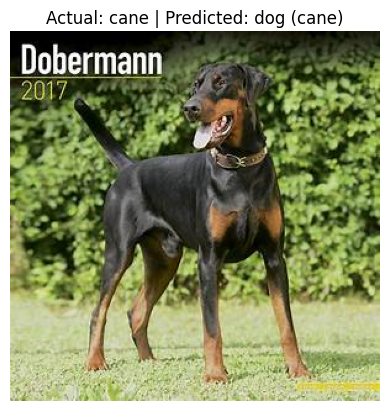

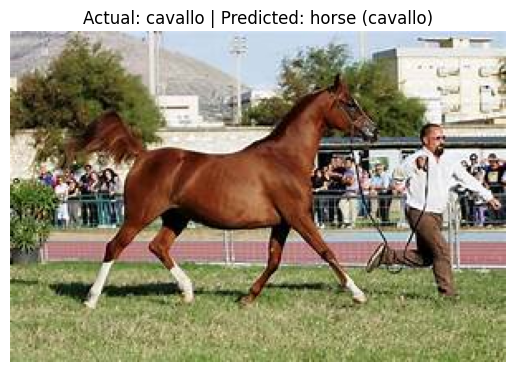

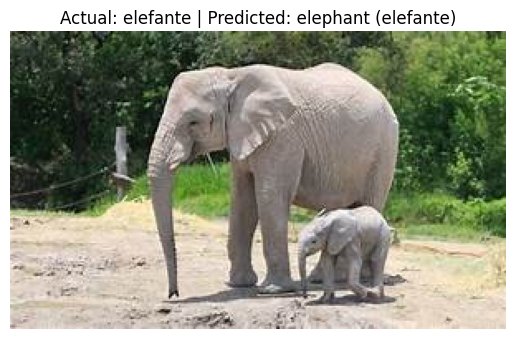

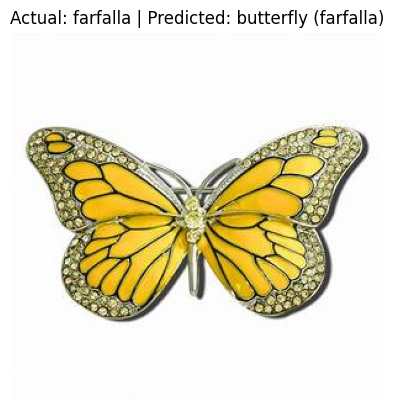

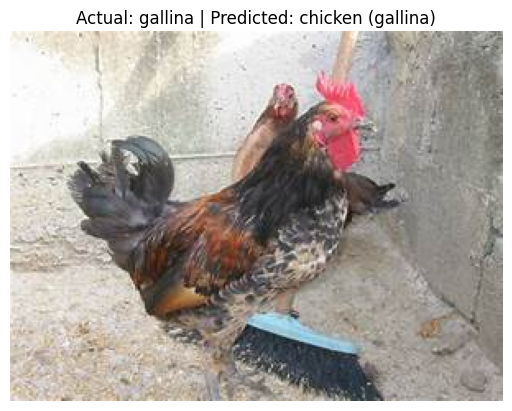

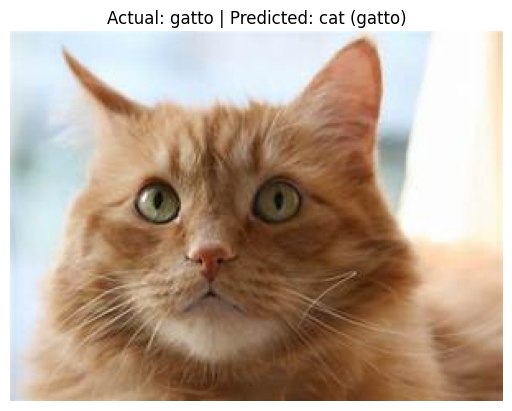

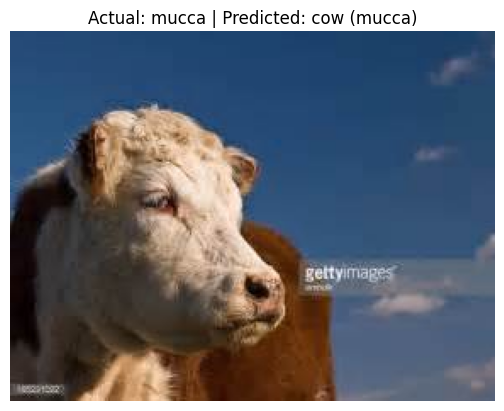

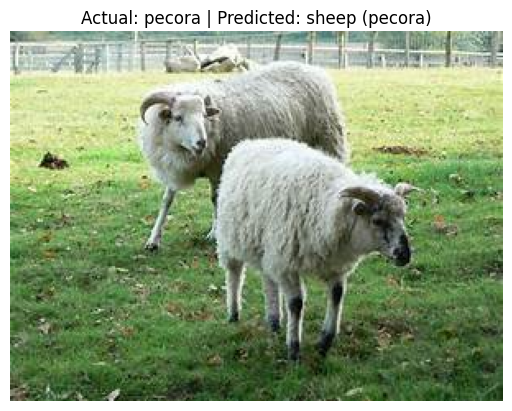

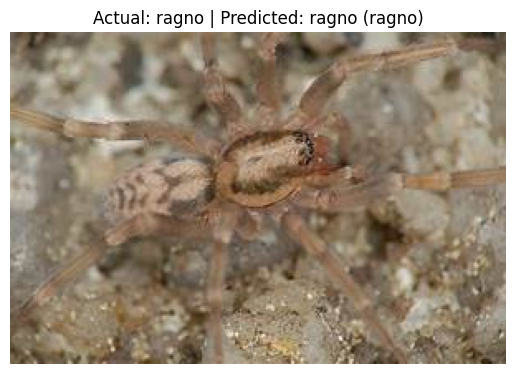

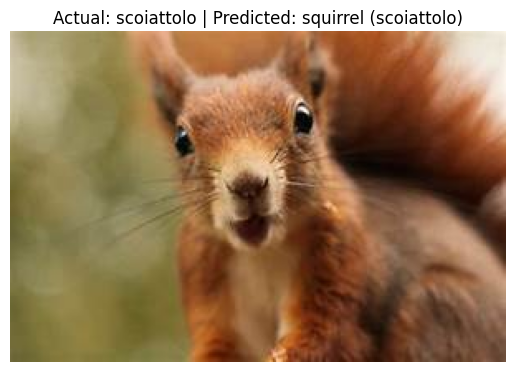

In [25]:
# Define batch size and image dimensions
BATCH_SIZE = 32
IMG_HEIGHT = 128  # Adjust according to your dataset
IMG_WIDTH = 128   # Adjust according to your dataset

# Define the translation dictionary
translate = {
    "cane": "dog", "cavallo": "horse", "elefante": "elephant", "farfalla": "butterfly", 
    "gallina": "chicken", "gatto": "cat", "mucca": "cow", "pecora": "sheep", 
    "scoiattolo": "squirrel", "dog": "cane", "horse": "cavallo", "elephant": "elefante", 
    "butterfly": "farfalla", "chicken": "gallina", "cat": "gatto", "cow": "mucca", 
    "spider": "ragno", "squirrel": "scoiattolo"
}

# Define the categories (class names your model predicts)
categories = ['cane', 'cavallo', 'elefante', 'farfalla', 'gallina', 'gatto', 'mucca', 'pecora', 'ragno', 'scoiattolo']

# Define the dataset directory path (replace with your actual path)
dataset_dir = r'C:\Users\hp\.cache\kagglehub\datasets\alessiocorrado99\animals10\versions\2\raw-img'

# Define the transformations to match what was done during training
transform = transforms.Compose([
    transforms.Resize((IMG_HEIGHT, IMG_WIDTH)),  # Resize to match model input size
    transforms.ToTensor(),  # Convert image to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize the image
])

# Load the pre-trained AlexNet model and modify the final layer
model = models.alexnet(pretrained=False)  # Load AlexNet without pre-trained weights
model.classifier[6] = nn.Linear(model.classifier[6].in_features, len(categories))  # Modify the final layer

# Load the saved model weights (ensure this path is correct relative to your script)
model_path = './logs/alexnet_trained_model_2025-01-16_19-57-23.pth'  # Using relative path if the model is in the same directory
model.load_state_dict(torch.load(model_path))
model.eval()  # Set the model to evaluation mode

# Function to test a random image from each class
def test_random_images(model, categories, dataset_dir, transform):
    model.eval()  # Set the model to evaluation mode
    for category in categories:
        # Get all image files in the current category directory
        class_dir = os.path.join(dataset_dir, category)
        image_files = os.listdir(class_dir)
        
        if not image_files:
            print(f"No images found in {class_dir}")
            continue

        # Select a random image
        random_image = random.choice(image_files)
        image_path = os.path.join(class_dir, random_image)
        
        # Open and preprocess the image
        try:
            img = Image.open(image_path).convert('RGB')
        except Exception as e:
            print(f"Failed to load image {image_path}: {e}")
            continue

        img_tensor = transform(img).unsqueeze(0)  # Add batch dimension
        
        # Make prediction
        with torch.no_grad():
            outputs = model(img_tensor)  # Get model output
            _, predicted_class_idx = torch.max(outputs, 1)  # Get index of the max value in the output
        
        # Get the predicted class label
        predicted_class_label = categories[predicted_class_idx.item()]  # Convert the index to class label
        
        # Translate the predicted class label
        translated_label = translate.get(predicted_class_label, predicted_class_label)  # Get the translated label or keep the original if not found
        
        # Display the image and the translated prediction
        plt.imshow(img)
        plt.title(f"Actual: {category} | Predicted: {translated_label} ({predicted_class_label})")
        plt.axis('off')  # Hide the axes for a cleaner view
        plt.show()

# Test random images from each class
test_random_images(model, categories, dataset_dir, transform)
